In [ ]:
using Distributed, Printf, DelimitedFiles, Glob

using PyPlot
using LaTeXStrings

# Caution here, do not use more processes than the number of cores
addprocs(8);

In [ ]:
@everywhere using LinearAlgebra, Distributions, Statistics, DataFrames, CSV, SharedArrays

@everywhere function parametrize_SCM(A, γ1, γ2, γ3, γ4, μ, cross_stage_interaction_type, intra_stage_interaction_type)

    # The connectivity of the interaction matrix is fixed by the input matrix A (the empirical interaction matrix).
    # We extend the interaction matrix to include juvenile and adult life stages of each species, building the structured community matrix (SCM).
    
    # Adult-juvenile interactions are fixed by the cross-stage interaction type, which must correspond to the type of interaction in the empirical interaction matrix. (e.g. if the empirical interaction matrix is a food web, then the cross-stage interaction type must be predator-prey).
    # Adult-adult and juvenile-juvenile interactions are either random, competitive, mutualistic or predator-prey, depending on the intra-stage interaction type.

    # We have only implemented the case where the cross-stage interaction type is predator-prey, and the intra-stage interaction type can be random, competition or mutualism.
    # In nay case, the implementation of other type of cross-stage interaction types is straightforward.
    
    S = size(A, 1)  # number of species
    C = count(!iszero, A) / (S * (S - 1))

    # Initialize structured community matrix
    SCM = zeros(2*S, 2*S)
    
    SCM[1:S, 1:S] .= A
    SCM[S+1:end, 1:S] .= A
    SCM[1:S, S+1:end] .= A
    SCM[S+1:end, S+1:end] .= A

    if cross_stage_interaction_type == "predation"

        # Adult-juvenile interactions are always predator-prey (as it is a food web).
        # Adult-adult and juvenile-juvenile interactions are either random, competitive, mutualistic or also predator-prey.
    
        σ2 = (γ2 / sqrt(S * C)) * (π / (π - 2))
        σ3 = (γ3 / sqrt(S * C)) * (π / (π - 2))

        if intra_stage_interaction_type == "random"
            
            σ1 = γ1 / sqrt(S * C)
            σ4 = γ4 / sqrt(S * C)

            SCM[1:S, 1:S] .= abs.(SCM[1:S, 1:S]) .* rand(Normal(0, σ1), S, S)
            SCM[S+1:end, S+1:end] .= abs.(SCM[S+1:end, S+1:end]) .* rand(Normal(0, σ4), S, S)

            SCM[S+1:end, 1:S] .= SCM[S+1:end, 1:S] .* abs.(rand(Normal(0, σ2), S, S))
            SCM[1:S, S+1:end] .= SCM[1:S, S+1:end] .* abs.(rand(Normal(0, σ3), S, S))

        elseif intra_stage_interaction_type == "competition"
            
            denom = sqrt(S * C) * (1 + (2 - 2 * C) / (π - 2 * C)) * sqrt((π - 2 * C) / π) + C * sqrt(2 / π)
            σ1 = γ1 / denom
            σ4 = γ4 / denom

            SCM[1:S, 1:S] .= -1 .* abs.(SCM[1:S, 1:S]) .* abs.(rand(Normal(0, σ1), S, S))
            SCM[S+1:end, S+1:end] .= -1 .* abs.(SCM[S+1:end, S+1:end]) .* abs.(rand(Normal(0, σ4), S, S))

            SCM[S+1:end, 1:S] .= SCM[S+1:end, 1:S] .* abs.(rand(Normal(0, σ2), S, S))
            SCM[1:S, S+1:end] .= SCM[1:S, S+1:end] .* abs.(rand(Normal(0, σ3), S, S))

        elseif intra_stage_interaction_type == "mutualism"

            σ1 = (γ1 / ((S - 1) * C)) * sqrt(π / 2)
            σ4 = (γ4 / ((S - 1) * C)) * sqrt(π / 2)

            SCM[1:S, 1:S] .= abs.(SCM[1:S, 1:S]) .* abs.(rand(Normal(0, σ1), S, S))
            SCM[S+1:end, S+1:end] .= abs.(SCM[S+1:end, S+1:end]) .* abs.(rand(Normal(0, σ4), S, S))

            SCM[S+1:end, 1:S] .= SCM[S+1:end, 1:S] .* abs.(rand(Normal(0, σ2), S, S))
            SCM[1:S, S+1:end] .= SCM[1:S, S+1:end] .* abs.(rand(Normal(0, σ3), S, S))

        else
            error("interaction_type must be one of 'random', 'competition', or 'mutualism'")
        end

    elseif cross_stage_interaction_type == "mutualism"

        error("cross_stage_interaction_type 'mutualism' not implemented yet")

    elseif cross_stage_interaction_type == "competition"

        error("cross_stage_interaction_type 'competition' not implemented yet")

    else
        error("cross_stage_interaction_type must be one of 'predator-prey', 'mutualism', or 'competition'")
    end

    SCM[diagind(SCM)] .= -μ

    return SCM
end

function stability_experiment(network_name, network_type, γ1, γ2s, γ3s, γ4, μ, cross_stage_interaction_type, intra_stage_interaction_type, realizations)

    # Create folder if it doesn't exist
    if !isdir("Results_empirical/$(network_type)")
        mkdir("Results_empirical/$(network_type)")
    end

    # Load empirical interaction matrix
    A_df = CSV.read("Data/web-of-life_$(network_type)/$(network_name).csv", DataFrame)
    A = Matrix(A_df[:, 2:end])   

    result_filename = "Results_empirical/$(network_type)/stability_$(network_name)_$(intra_stage_interaction_type)_γ1_$(γ1)_γ4_$(γ4)_μ_$(μ)_realizations_$(realizations).txt"

    f = open(result_filename, "w")
    write(f, "γ₂, γ₃, stability, std_err\n")

    i = 0
    for γ2 in γ2s

        i += 1
        j = 0

        for γ3 in γ3s

            j += 1

            @printf "\r\tComputing for γ₂ = %.2f and γ₃ = %.2f" γ2 γ3
            flush(stdout)

            # stable = zeros(realizations)
            stable = SharedArray{Int}(realizations)

            @sync @distributed for k in 1:realizations
                
                SCM = parametrize_SCM(A, γ1, γ2, γ3, γ4, μ, cross_stage_interaction_type, intra_stage_interaction_type)

                λmax = maximum(real(eigvals(SCM)))
                
                if λmax < 0
                    stable[k] = 1
                else
                    stable[k] = 0
                end
                
            end

            stability = mean(stable)
            std_err = std(stable) / sqrt(realizations)

            writedlm(f, [γ2 γ3 stability std_err])

        end
    end

    close(f)

    println("\n\tResults saved to $(result_filename)")

end

function phase_space_point_eigenvalues_all(network_type, γ1, γ2, γ3, γ4, μ, cross_stage_interaction_type, intra_stage_interaction_type, realizations)

    realizations = 1000

    max_eigenvalues_all = []

    network_names = [split(split(name, "/")[end], ".")[1] for name in glob("Data/web-of-life_food_webs/A*.csv")]

    tot_names = length(network_names)

    k=0
    for name in network_names

        k += 1

        println("Running stability experiment for network: $(name) ($k of $tot_names)")

        A_df = CSV.read("Data/web-of-life_$(network_type)/$(name).csv", DataFrame)
        A = Matrix(A_df[:, 2:end])   

        max_eigenvalues = SharedArray{Float64}(realizations)

        @sync @distributed for k in 1:realizations
                        
            SCM = parametrize_SCM(A, γ1, γ2, γ3, γ4, μ, cross_stage_interaction_type, intra_stage_interaction_type)

            λmax = maximum(real(eigvals(SCM)))

            max_eigenvalues[k] = λmax
            
        end

        push!(max_eigenvalues_all, Array(max_eigenvalues))
    end

    return max_eigenvalues_all

end

if !isdir("Results_empirical/")
    mkdir("Results_empirical")
end

"Results_empirical"

# Stability analysis

In [ ]:
## Takes about 15 mins to complete with 8 processes in a computer with i7 CPUs ##

# Parameters
γ1 = 1.2
γ4 = 0.0
μ = 1.0

cross_stage_interaction_type = "predation"
intra_stage_interaction_type = "random"  # "random", "competition", "mutualism" or "predation"

realizations = 1000

network_type = "food_webs"

γ2s = 0.0:0.05:2.0
γ3s = 0.0:0.05:2.0

network_name = "A_FW_013_02"

println("Running stability experiment for network: $(network_name)")

@time stability_experiment(network_name, network_type, γ1, γ2s, γ3s, γ4, μ, cross_stage_interaction_type, intra_stage_interaction_type, realizations)

Running stability experiment for network: A_FW_013_02
	Computing for γ₂ = 2.00 and γ₃ = 2.00
	Results saved to Results_empirical/food_webs/stability_A_FW_013_02_random_γ1_1.2_γ4_0.0_μ_1.0_realizations_1000.txt
830.595404 seconds (7.86 M allocations: 996.206 MiB, 0.01% gc time, 0.59% compilation time: 78% of which was recompilation)


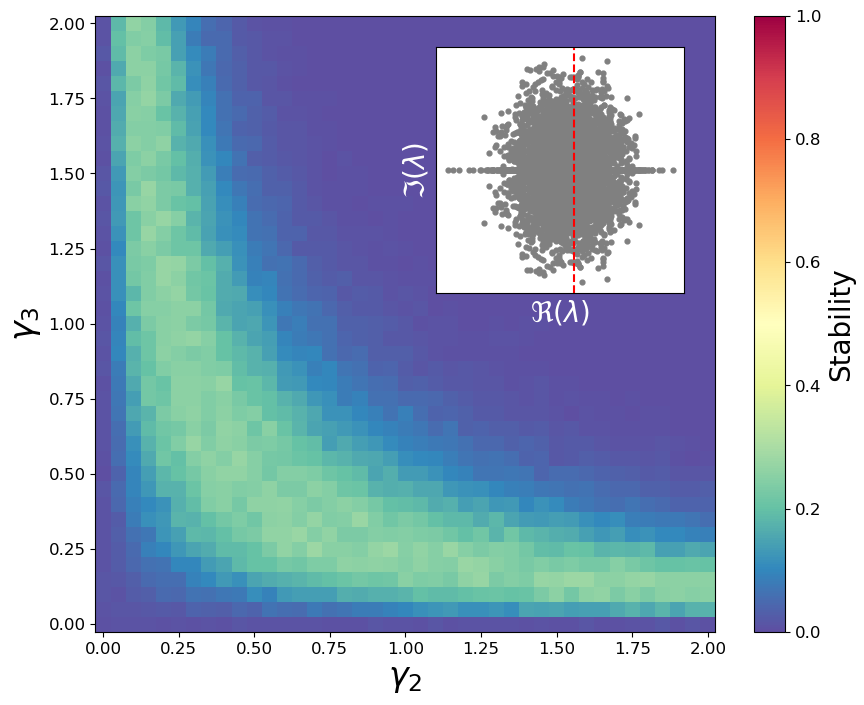

In [9]:
name = "FW_013_02"

data, header = readdlm("Results_empirical/food_webs/stability_A_$(name)_random_γ1_1.2_γ4_0.0_μ_1.0_realizations_1000.txt", header=true)

A = CSV.read("Data/web-of-life_food_webs/A_$(name).csv", DataFrame)
A = Matrix(A[:, 2:end])

S = size(A, 1)
C = count(!iszero, A) / (S * (S - 1))

γ1 = 1.2

σ1 = γ1 / sqrt(S * C)

eigvals_tot = []

for k in 1:100

    M = abs.(A) * rand(Normal(0, σ1), S, S)
    M[diagind(M)] .= -1

    λs = eigvals(M);

    append!(eigvals_tot, λs)

end


γ2s = unique(data[:, 1])
γ3s = unique(data[:, 2])
stability = data[:, 3]
std_err = data[:, 4]

# Reshape
stability_matrix = reshape(stability, length(γ2s), length(γ3s))
std_err_matrix = reshape(std_err, length(γ2s), length(γ3s));

plt.figure(figsize=(10, 8))

plt.pcolormesh(γ2s, γ3s, stability_matrix, cmap="Spectral_r", vmin=0, vmax=1)

cbar = plt.colorbar()

cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel("Stability", fontsize=20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel(L"\gamma_2", fontsize=24)
plt.ylabel(L"\gamma_3", fontsize=24)

axins = plt.gca().inset_axes([0.55, 0.55, 0.4, 0.4])

axins.scatter(real(eigvals_tot), imag(eigvals_tot), s=12, color="gray")
axins.axvline(0, color="r", ls="--")

axins.set_xticks([])
axins.set_yticks([])

axins.set_xlabel(L"\Re(\lambda)", fontsize=20, color="w")
axins.set_ylabel(L"\Im(\lambda)", fontsize=20, color="w")

# plt.savefig("Empirical_food_web_stability.png", dpi=300)

gcf()